In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks

In [2]:
def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

In [3]:
img_test = HDF5Matrix('/cluster/home/rohrbjan/joint_scoring/img_test_regression.h5', 'img_test_regression')

In [4]:
model = load_model("/cluster/home/rohrbjan/joint_scoring/models/20171128_000703.h5", custom_objects={'crps': crps})

In [6]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

img_test_rgb = []

for i, img in enumerate(img_test):
    if i % 1000 == 0:
        clear_output()
        print("Converting test images to RGB, {0:.2f} % finished".format(i/72625*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_test_rgb.append(dat)

Converting test images to RGB, 26.16 % finished


In [7]:
img_test_rgb = np.array(img_test_rgb)

In [8]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

img_test_rgb = [preprocess_input(x) for x in img_test_rgb.astype("float32")]

In [9]:
img_test_rgb = np.array(img_test_rgb)

In [10]:
p = model.predict(img_test_rgb)
print(p.shape)

pred = np.zeros(p.shape[0])
print(pred.shape)

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

(19709, 101)
(19709,)


In [14]:
labels_test_reg = HDF5Matrix('/cluster/home/rohrbjan/joint_scoring/labels_test_regression.h5', 'labels_test_regression')

In [15]:
def cdf(label):
    arr = np.zeros(101)
    arr[int(label):] = 1
    return arr

labels_test = [cdf(x) for x in labels_test_reg]
labels_test = np.array(labels_test)

In [16]:
model.evaluate(x=img_test_rgb, y=labels_test)
# [loss, metric]

19680/19709 [============================>.] - ETA: 0s

[0.027391466447492189, 0.032458308266310507]

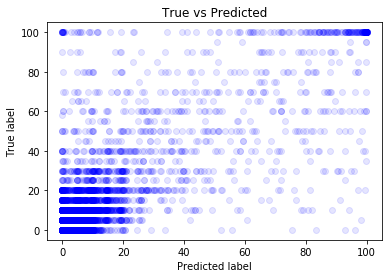

In [17]:
plt.title("True vs Predicted")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.scatter(x=pred, y=labels_test_reg, color="blue", alpha=0.1)

plt.show()

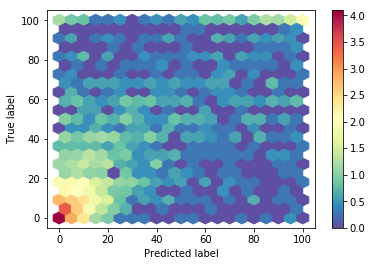

In [18]:
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.hexbin(x=pred, y=labels_test_reg, gridsize=20, bins='log', cmap=plt.cm.Spectral_r)
plt.colorbar()

plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
mean_absolute_error(y_true=labels_test_reg, y_pred=pred)

3.1192657559954342

In [21]:
mean_squared_error(y_true=labels_test_reg, y_pred=pred)

72.770469659481719

In [22]:
r2_score(y_true=labels_test_reg, y_pred=pred)

0.65273475777957501

In [23]:
def transform2classes(x):
    if x < 1:
        return 0
    elif x <= 20:
        return 1
    elif x <= 40:
        return 2
    elif x <= 60:
        return 3
    elif x <= 80:
        return 4
    else:
        return 5

In [24]:
pred_clas = np.zeros(len(pred))
labels_clas = np.zeros(len(pred))

for i in range(len(pred)):
    pred_clas[i] = transform2classes(pred[i])
    labels_clas[i] = transform2classes(labels_test_reg[i])

In [25]:
print(sum(pred_clas == labels_clas) / len(labels_clas))

0.761834694809


In [26]:
print(classification_report(labels_clas, pred_clas))
cnf_matrix = confusion_matrix(labels_clas, pred_clas)
print(cnf_matrix)

             precision    recall  f1-score   support

        0.0       0.82      0.90      0.86     13457
        1.0       0.61      0.49      0.54      5286
        2.0       0.32      0.23      0.27       384
        3.0       0.28      0.20      0.23       193
        4.0       0.26      0.23      0.25       124
        5.0       0.70      0.65      0.67       265

avg / total       0.75      0.76      0.75     19709

[[12102  1343     6     2     1     3]
 [ 2562  2587    96    20    12     9]
 [   27   204    88    31    16    18]
 [    8    45    56    38    22    24]
 [    2    28    20    26    29    19]
 [   16    21     8    17    32   171]]


Confusion matrix, without normalization
[[12102  1343     6     2     1     3]
 [ 2562  2587    96    20    12     9]
 [   27   204    88    31    16    18]
 [    8    45    56    38    22    24]
 [    2    28    20    26    29    19]
 [   16    21     8    17    32   171]]
Normalized confusion matrix
[[  8.99308910e-01   9.97993609e-02   4.45864606e-04   1.48621535e-04
    7.43107676e-05   2.22932303e-04]
 [  4.84676504e-01   4.89405978e-01   1.81611805e-02   3.78357927e-03
    2.27014756e-03   1.70261067e-03]
 [  7.03125000e-02   5.31250000e-01   2.29166667e-01   8.07291667e-02
    4.16666667e-02   4.68750000e-02]
 [  4.14507772e-02   2.33160622e-01   2.90155440e-01   1.96891192e-01
    1.13989637e-01   1.24352332e-01]
 [  1.61290323e-02   2.25806452e-01   1.61290323e-01   2.09677419e-01
    2.33870968e-01   1.53225806e-01]
 [  6.03773585e-02   7.92452830e-02   3.01886792e-02   6.41509434e-02
    1.20754717e-01   6.45283019e-01]]


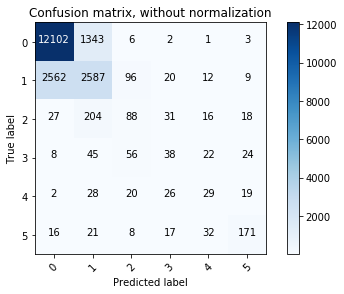

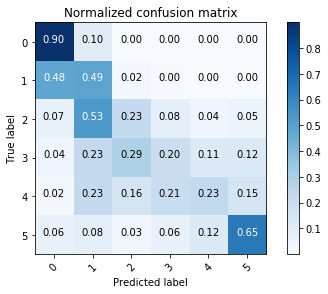

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(6),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(6), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [28]:
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Mean accuracy per class")
print(np.mean(np.diag(cm)))

Mean accuracy per class
0.448987788817


In [29]:
upper = np.diag(cm, 1)
upper = np.append(upper, 0)
diagonal = np.diag(cm)
lower = np.diag(cm, -1)
lower = np.append(0, lower)

arr = np.vstack((upper, diagonal, lower))
print("Mean accuracy in the correct class or +- 1")
print(arr.sum(axis=0).mean())

Mean accuracy in the correct class or +- 1
0.799390994242
